In [1]:
import sys
sys.path.append('/home/monte.flora/python_packages/scikit-explain/')
sys.path.append('/home/monte.flora/python_packages/scikit-explain/tutorial_notebooks')
sys.path.append('/home/monte.flora/python_packages/master/ml_workflow')
sys.path.append('/work/mflora/ROAD_SURFACE')
import skexplain
import shap
import plotting_config
from skexplain.plot.base_plotting import PlotStructure
from skexplain.common.contrib_utils import get_indices_based_on_performance
import numpy as np
from bayeshist import bayesian_histogram
import matplotlib.pyplot as plt

from load_models_and_data import load_model_and_data
from probsr_config import FIGURE_MAPPINGS, UNITS
from display_names import to_readable_names, get_units
from load_explain_data import load_explain
import similaritymeasures
from scipy.interpolate import interp1d
from top_features import top_features

In [2]:
def shap_to_curve(feature, shap_vals, X, bins):
    """Convert SHAP dots to a mean curve"""
    vals = shap_vals[feature]
    feature_vals = X[feature]
    
    inds = np.digitize(feature_vals, bins=bins) - 1
    mean_shap_vals = np.array([np.mean(vals.values[inds==i]) for i in np.unique(inds)])
    mean_shap_vals = 0.5*(mean_shap_vals[:-1]+mean_shap_vals[1:])
    
    return mean_shap_vals

In [3]:
from scipy.stats import spearmanr

def normalize(d):
    denom = (np.max(d) - np.min(d))
    if denom < 0.0000001:
        denom = 0.00001
    
    return d / denom

def rmse(d1, d2):
    return np.sqrt(np.mean((d1-d2)**2))
    

def measure_corr(ale, shap_vals, pd, name='LogisticRegression', features=None):
    
    vals = {'ale' : [], 'shap' : [], 'pd' : []}
    val_weights = []
    
    if features is None:
        features = ale.attrs['features used']
    
    for feature in features:
        if feature in ['rural', 'urban']:
            continue
    
        ale_x = ale[f'{feature}__bin_values'].values
        ale_y =  np.mean(ale[f'{feature}__{name}__ale'].values, axis=0)
        
        pd_x = pd[f'{feature}__bin_values'].values
        pd_y = np.mean(pd[f'{feature}__{name}__pd'].values, axis=0)
        
        mean_shap = shap_to_curve(feature, shap_vals, X_shap, ale_x)
        
        data = X[feature].values.astype(float)
        bin_edges, beta_dist = bayesian_histogram(data, y)
        bin_centers = 0.5*(bin_edges[:-1] + bin_edges[1:])
        
        base_rate = beta_dist.median()
        ale_func = interp1d(ale_x, ale_y, fill_value="extrapolate")
        
        try:
            shap_func = interp1d(ale_x, mean_shap, fill_value="extrapolate")
        except:
            shap_func = interp1d(ale_x[:-1], mean_shap, fill_value="extrapolate")
            
        pd_func = interp1d(pd_x, pd_y, fill_value="extrapolate")
        
        ale_new = ale_func(bin_centers)
        shap_new = shap_func(bin_centers)
        pd_new = pd_func(bin_centers)
        
        if name == 'Random Forest':
            fig = plt.figure(dpi=250)
            for d, label in zip([ale_new, shap_new, pd_new, base_rate], 
                     ['ALE', 'SHAP', 'PD', 'BR']
                    ):
            
                norm_d = d / (np.max(d) - np.min(d))
                plt.plot(bin_centers, norm_d, label=label)
            
            #corr = np.corrcoef(d, base_rate)[0][1]
            ##plt.scatter(base_rate, d, label=f'{label} : {corr:.3f}')
            #plt.plot(base_rate, d)
            #plt.xlabel('Base Rate')
            #plt.ylabel('Feature Effect')
        plt.legend()

        br_norm = normalize(base_rate)

        vals['ale'].append(rmse(normalize(ale_new), br_norm))
        vals['pd'].append(rmse(normalize(pd_new), br_norm))
        vals['shap'].append(rmse(normalize(shap_new), br_norm))
    
        val_weights.append(np.var(base_rate))

    return vals, val_weights

In [8]:
keys = ['ale', 'shap', 'pd']

data = [] 
hazards = ['road_surface']#['tornado', 'severe_hail', 'severe_wind', 'road_surface']
for hazard in hazards: 
    (name, _), X, y = load_model_and_data(hazard, test=False)
    ale, _, shap_vals, X_shap, pd = load_explain(hazard, X.columns, return_pd=True)
    corr, weights = measure_corr(ale, shap_vals, pd, name, features)
    row = [np.average(corr[key], weights=weights) for key in keys]
    data.append(row)

NameError: name 'features' is not defined

In [ ]:
import pandas as pd
columns = ['ALE', 'SHAP', 'PD']
df = pd.DataFrame(data, columns=columns)

In [ ]:
fig, ax = plt.subplots(dpi=300)
hazards = ['Tornado', 'Severe Hail', 'Severe Wind', 'Road Surface']

x = np.arange(len(hazards))  # the label locations
width = 0.15  # the width of the bars

ax.bar(x - width, df['ALE'], width=width, label='ALE')
ax.bar(x , df['SHAP'], width=width, label='SHAP')
ax.bar(x + width, df['PD'], width=width, label='PD')

ax.set_ylabel('Feature-Average\nRMSD(Feature Effects, Base Rate)', fontsize=8)
ax.set_xticks(np.arange(len(hazards)))
ax.set_xticklabels(hazards)
ax.legend()

overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp
overflow encountered in exp


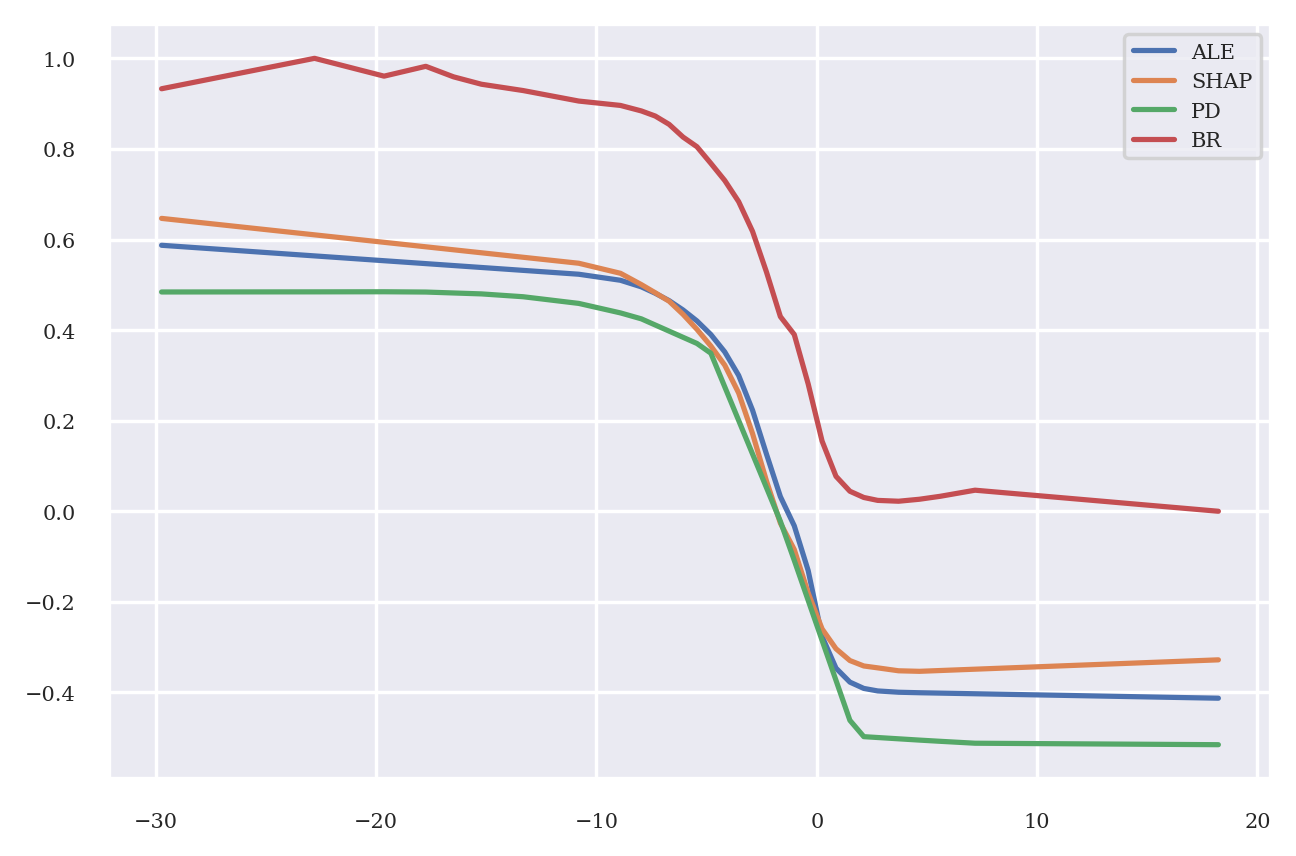

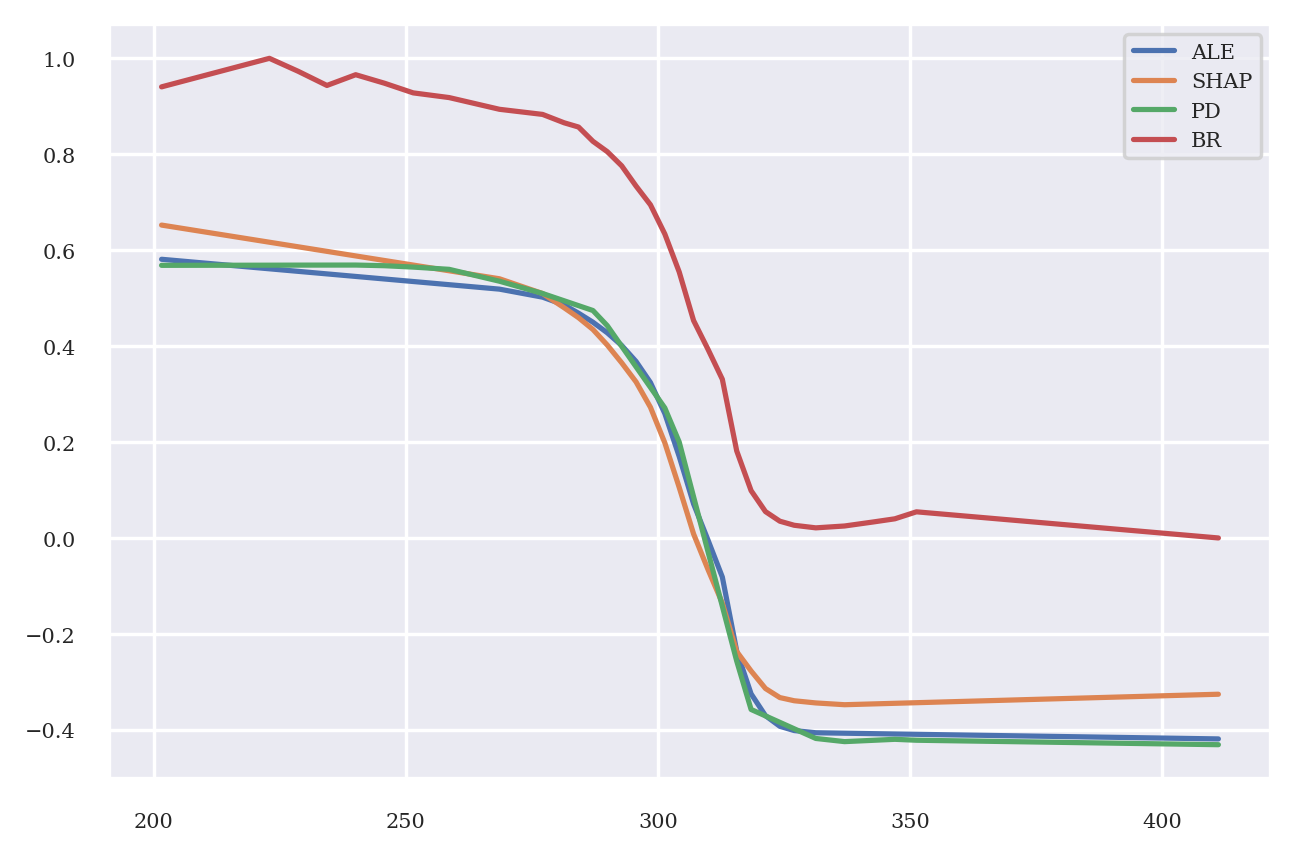

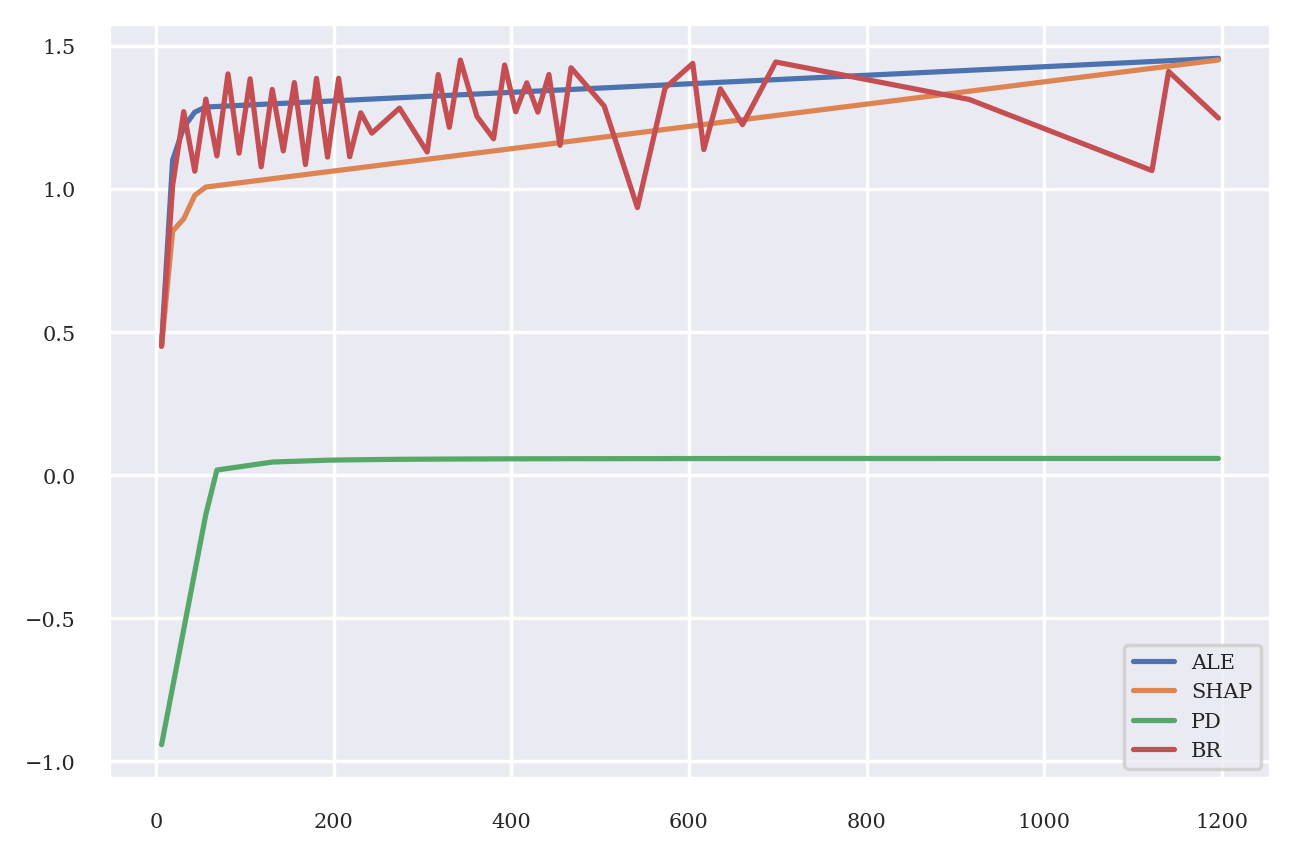

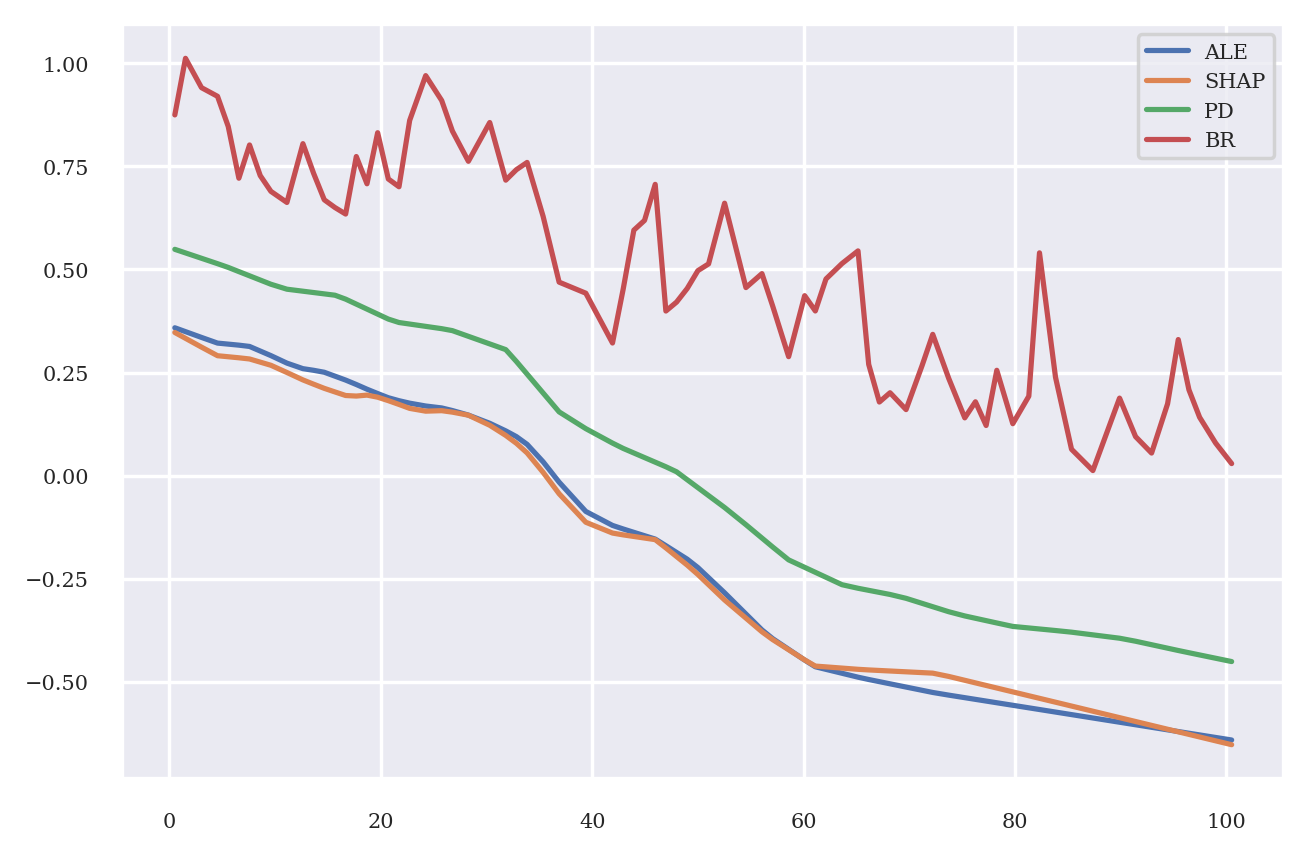

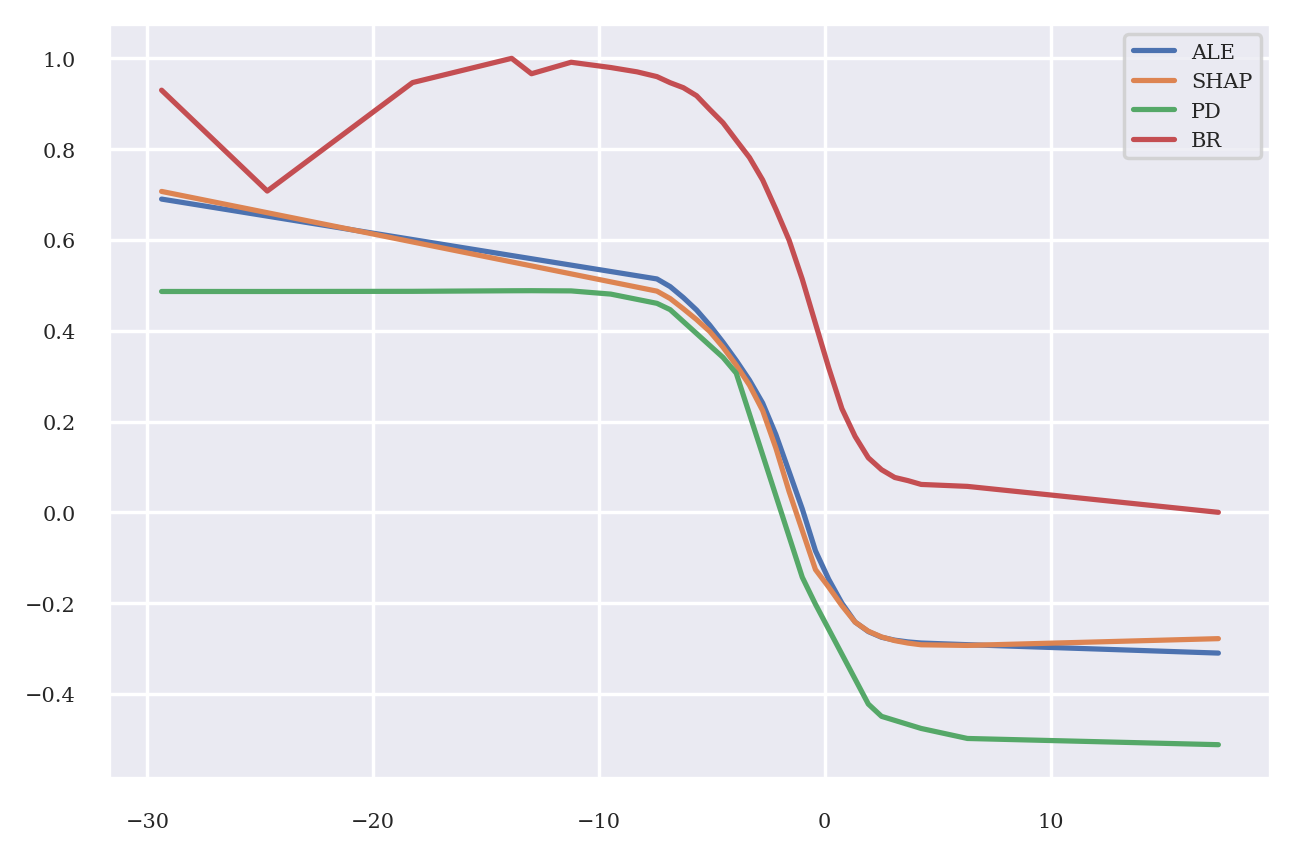

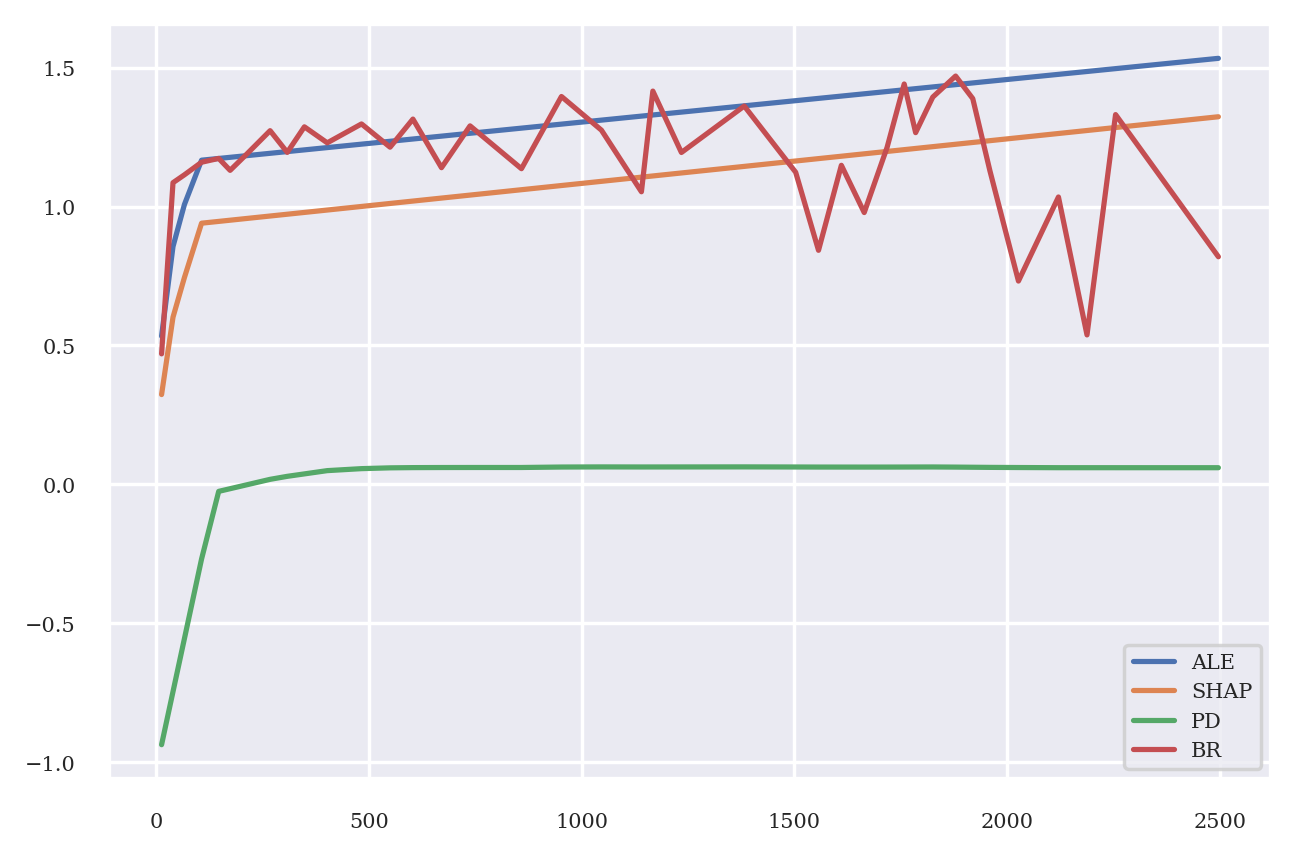

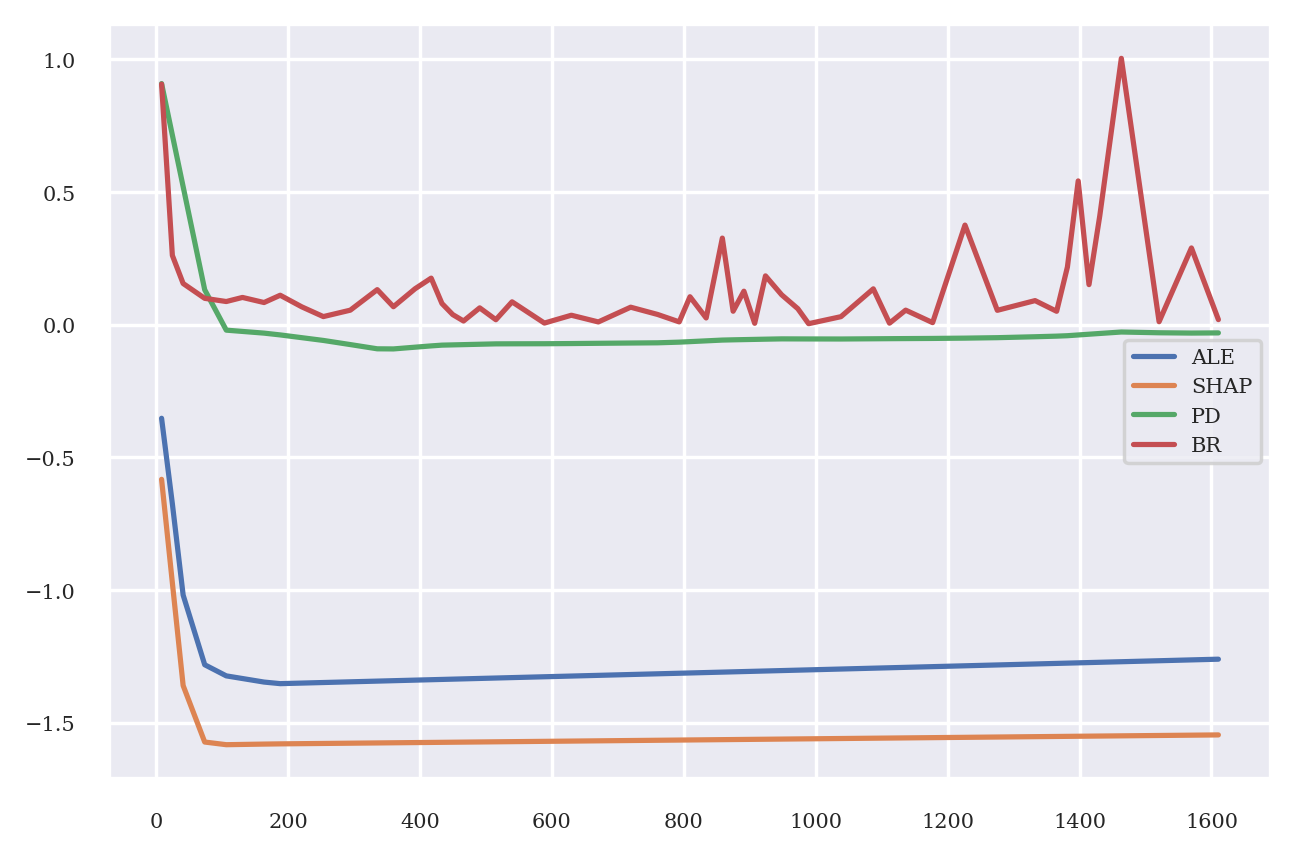

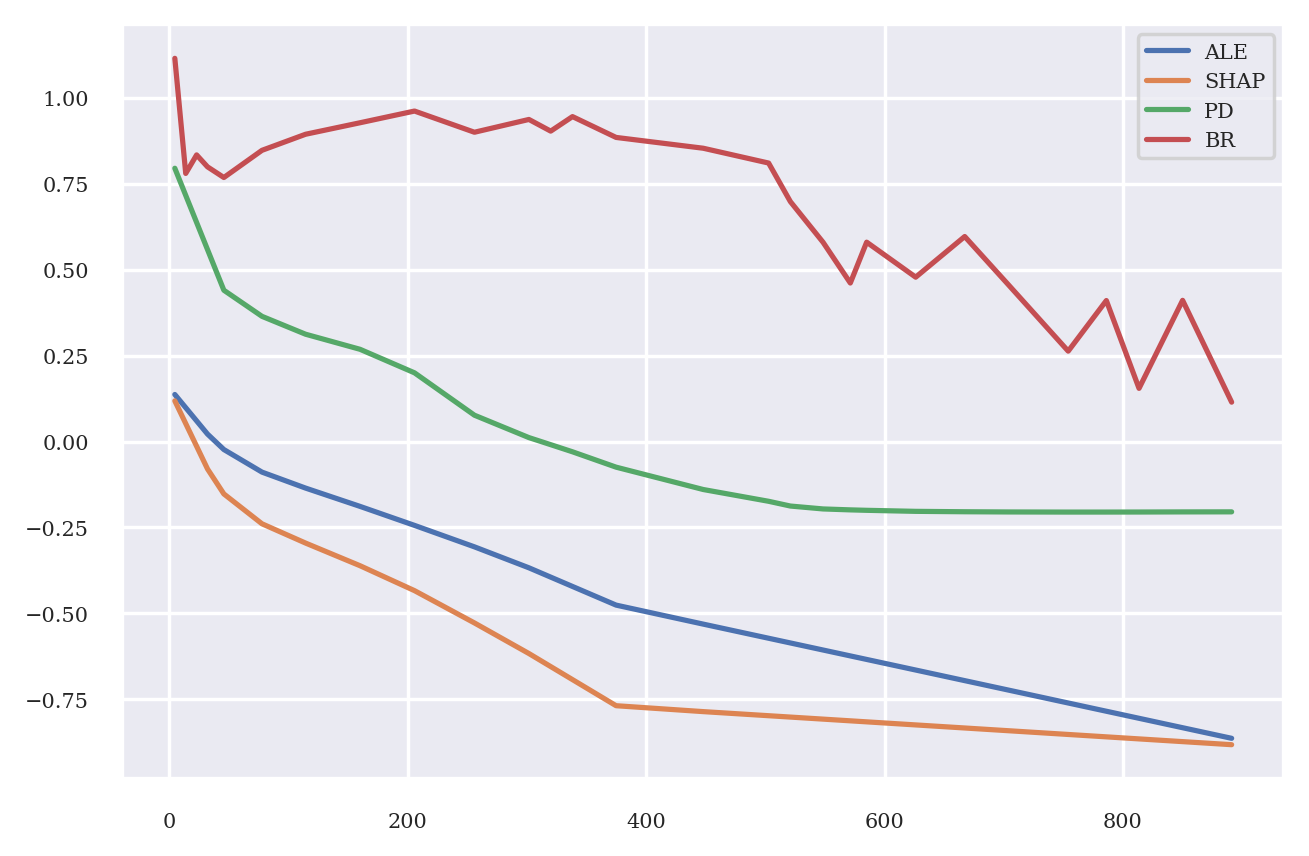

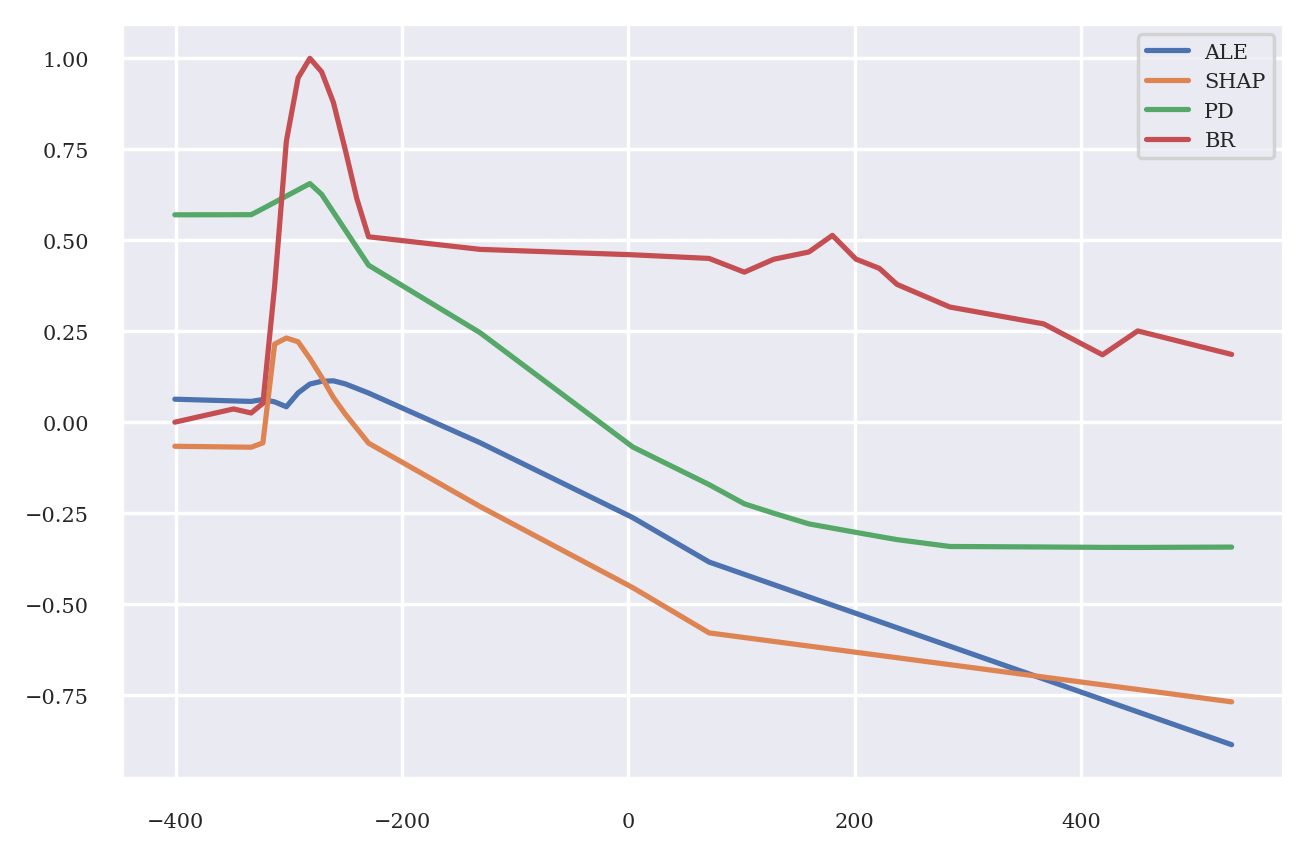

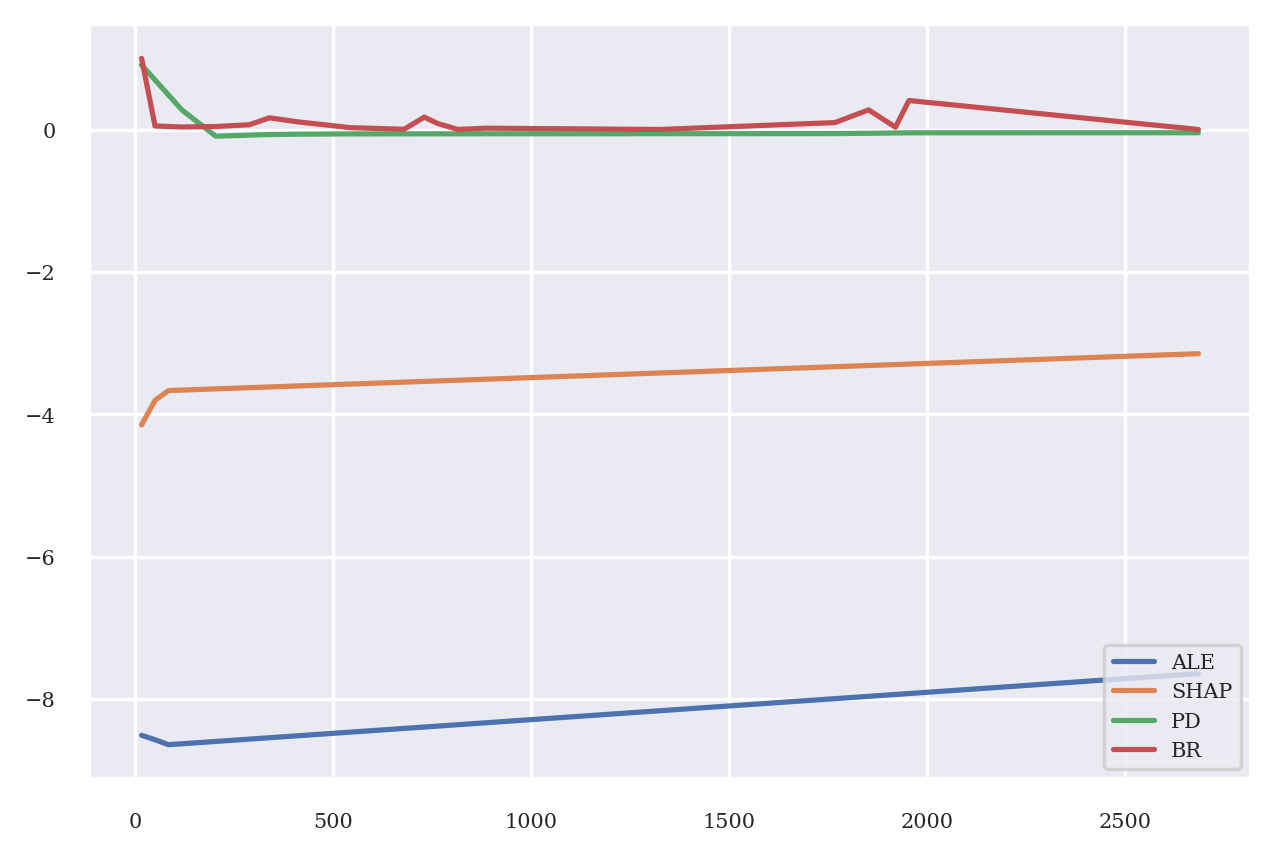

In [9]:
keys = ['ale', 'shap', 'pd']
data = [] 
hazards = ['road_surface']#['tornado', 'severe_hail', 'severe_wind', 'road_surface']
for hazard in hazards: 
    (name, _), X, y = load_model_and_data(hazard, test=False)
    ale, _, shap_vals, X_shap, pd = load_explain(hazard, X.columns, return_pd=True)
    corr, weights = measure_corr(ale, shap_vals, pd, name, features=top_features[hazard])
    row = [np.average(corr[key], weights=weights) for key in keys]
    data.append(row)

In [10]:
import pandas as pd
columns = ['ALE', 'SHAP', 'PD']
df = pd.DataFrame(data, columns=columns)

In [11]:
df

,ALE,SHAP,PD
0,0.630113,0.553487,0.522357


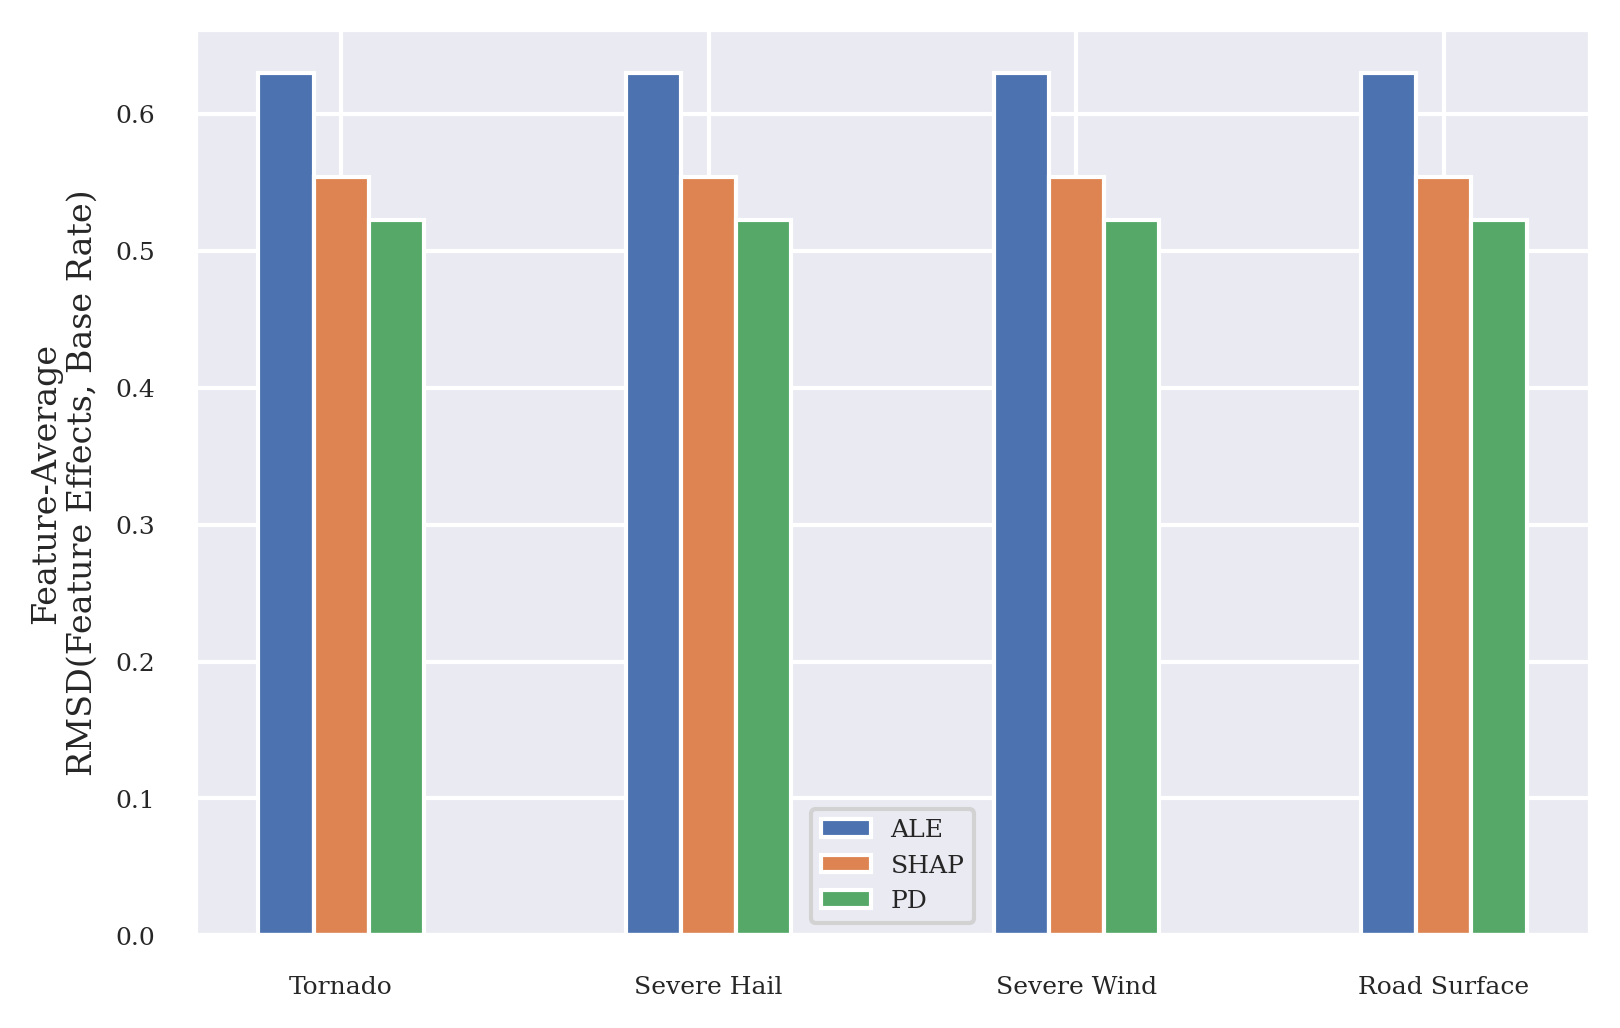

In [12]:
fig, ax = plt.subplots(dpi=300)
hazards = ['Tornado', 'Severe Hail', 'Severe Wind', 'Road Surface']

x = np.arange(len(hazards))  # the label locations
width = 0.15  # the width of the bars

ax.bar(x - width, df['ALE'], width=width, label='ALE')
ax.bar(x , df['SHAP'], width=width, label='SHAP')
ax.bar(x + width, df['PD'], width=width, label='PD')

ax.set_ylabel('Feature-Average\nRMSD(Feature Effects, Base Rate)', fontsize=8)
ax.set_xticks(np.arange(len(hazards)))
ax.set_xticklabels(hazards)
ax.legend()